In [0]:
# # The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse

# # Authentication for your google drive
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()

# # Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse


# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p MyDrive
!google-drive-ocamlfuse MyDrive
# %cd ML/AIML_Labs/

In [38]:
%cd MyDrive/ML/AIML_Labs/FinalHackathon

/content/MyDrive/ML/AIML_Labs/FinalHackathon/signs_data/train/right/MyDrive/ML/AIML_Labs/FinalHackathon


In [0]:
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
# import torch
# print(torch.__version__)
# print(torch.cuda.is_available())

In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

# Importing config.py file
# import config as cf
# from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

# import config as cf
from utils import *
from data_loader import *



In [39]:
!ls

camera_img.jpeg    Copy of car_turns.ipynb  Lab11-Experiment2_2.ipynb  utils.py
car_turns_1.ipynb  Data_Description.pdf     __pycache__
car_turns.ipynb    data_loader.py	    signs_data
config.py	   i_turn.pth.tar	    test_turn.ipynb


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

NUM_CLASSES = 6

In [0]:
data_dir = 'signs_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()

In [9]:
use_cuda, device

(True, device(type='cuda', index=0))

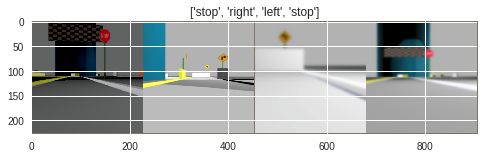

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [42]:
class_names

['left', 'misc', 'right', 'signal', 'stop', 'u_turn']

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


OSError: ignored

In [0]:
visualize_model(model_ft)

0.3.1


In [0]:
torch.__version__

'0.3.0.post4'

In [19]:
!ls signs_data/train/right/

signs_data/train/right/add_r2.png


In [24]:
%cd ../../..

/content/MyDrive/ML/AIML_Labs/FinalHackathon


In [27]:
%cd signs_data/train/right/

/content/MyDrive/ML/AIML_Labs/FinalHackathon/signs_data/train/right


In [22]:
!ls -l

total 12285
-rw-r--r-- 1 root root  14063 May 19 05:37 3.png
-rw-r--r-- 1 root root  54349 May 19 05:37 add1_r24.png
-rw-r--r-- 1 root root  60960 May 19 05:37 add1_r25.png
-rw-r--r-- 1 root root  82532 May 19 05:37 add1_r26.png
-rw-r--r-- 1 root root 103129 May 19 05:37 add1_r27.png
-rw-r--r-- 1 root root 117333 May 19 05:37 add1_r28.png
-rw-r--r-- 1 root root  47604 May 19 05:37 add1_r29.png
-rw-r--r-- 1 root root  67353 May 19 05:37 add1_r30.png
-rw-r--r-- 1 root root 116520 May 19 05:37 add1_r31.png
-rw-r--r-- 1 root root 207943 May 19 05:36 add1_r32.png
-rw-r--r-- 1 root root 220893 May 19 05:37 add1_r33.png
-rw-r--r-- 1 root root 187801 May 19 05:37 add1_r34.png
-rw-r--r-- 1 root root 188160 May 19 05:37 add1_r35.png
-rw-r--r-- 1 root root 154126 May 19 05:37 add1_r36.png
-rw-r--r-- 1 root root 186296 May 19 05:37 add1_r37.png
-rw-r--r-- 1 root root 121778 May 19 05:37 add1_r38.png
-rw-r--r-- 1 root root 120146 May 19 05:37 add1_r39.png
-rw-r--r-- 1 root root  79444 May 19 05:37 